In [1]:
import pandas as pd
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.io import read_image
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from numpy import asarray
from torch.backends import cuda

In [2]:
ds = pd.read_csv("data/train.csv")
test_ds = pd.read_csv("data/test.csv")

In [3]:
img_dir="Downloads/train/"

In [5]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform = None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = img_dir + self.dataframe.iloc[idx, 0]
        img = asarray(Image.open(img_path))
        label = torch.tensor(int(self.dataframe.iloc[idx, 1]))
        if self.transform:
            img = self.transform(img)
        return [img, label]

In [6]:
train_ds = ds.iloc[:15000,:]
val_ds = ds.iloc[15000:,:]

In [7]:
transform_img = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((150, 150)),
        transforms.ToTensor()
    ])

In [8]:
train_dataset = ImageDataset(train_ds, img_dir, transform_img)
val_dataset = ImageDataset(val_ds, img_dir, transform_img)

In [10]:
train_loader = DataLoader(train_dataset, 16, shuffle = True) 

In [11]:
val_loader =  DataLoader(val_dataset, 16) 

In [14]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

device(type='cuda')

In [15]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [16]:
class SceneClassificationModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 75 x 75

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(3, 3), # output: 128 x 25 x 25

            nn.Flatten(), 
            nn.Linear(128 * 25 * 25, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            
            nn.ReLU(),
            nn.Linear(128, 6))
        
    def forward(self, xb):
        return self.network(xb)

In [17]:
def accuracy(model, val_loader):
    acc = 0
    count = 0
    for batch in val_loader:
        images, labels = batch
        outputs = model(images)
        _, pred = torch.max(outputs, dim = 1)
        acc += torch.sum(pred == labels).item()
        count += len(images)
    return acc / count

In [18]:
def train(epoch, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epoch):
        epoch_loss = 0
        epoch_accuracy = 0
        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad()
            output = model(images)
            loss = F.cross_entropy(output, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
        epoch_loss = epoch_loss / len(train_loader)
        epoch_accuracy = accuracy(model ,val_loader)
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, epoch_loss, epoch_accuracy))

In [19]:
model = to_device(SceneClassificationModel(), device)

In [20]:
train(5, 0.0001, model, train_loader, val_loader, torch.optim.Adam)

Epoch [0], val_loss: 1.0579, val_acc: 0.6622
Epoch [1], val_loss: 0.7755, val_acc: 0.7183
Epoch [2], val_loss: 0.6206, val_acc: 0.7670
Epoch [3], val_loss: 0.5279, val_acc: 0.8127
Epoch [4], val_loss: 0.4483, val_acc: 0.8196


In [21]:
train(2, 0.00005, model, train_loader, val_loader, torch.optim.Adam)

Epoch [0], val_loss: 0.3487, val_acc: 0.8137
Epoch [1], val_loss: 0.3070, val_acc: 0.8432


In [22]:
def show_image_and_prediction(idx ,img_dir, test_ds):
    labels = {0: "Buildings", 1: "Forests", 2: "Mountains", 3: "Glacier", 4: "Sea", 5: "Street"}
    img_path = img_dir + test_ds.iloc[idx, 0]
    img = transform_img(asarray(Image.open(img_path)))
    out = model(img.unsqueeze(0).to(device=device))
    _, pred = out.max(1)
    print("Label: {}".format(labels[pred.item()]))
    plt.imshow(img.permute(1,2,0))

Label: Buildings


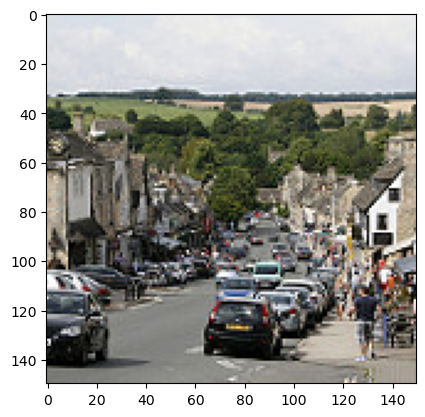

In [43]:
show_image_and_prediction(3110, img_dir, test_ds)